In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import numpy as np
import sys
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.8.0'

In [3]:
import cloudy

In [4]:
from cloudy import img_size, img_size_flat, img_shape, num_classes, num_channels

In [5]:
cloudy.data_dir = "data/clouds-images/"

In [6]:
#cloudy.maybe_download_and_extract()

In [7]:
dataset = cloudy.load()

Creating dataset from the files in: data/clouds-images/
- Data loaded from cache-file: data/clouds-images/clouds-images.pkl


In [8]:
class_names = dataset.class_names
class_names

['stratus', 'cirrus', 'cumulus', 'nimbus']

In [9]:
num_classes

4

In [10]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

In [11]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

In [12]:
image_paths_test[0]

'/home/sibonelo/cloudify/data/clouds-images/stratus/test/stratus_0_000.jpg'

In [13]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		167
- Test-set:		40


In [14]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 2)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 4 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name,
                                                       cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [54]:
from resizeimage import resizeimage
img_size = 200
import cv2

def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    if img is None:
        return None
    img = cv2.resize(img, (img_shape[0], img_shape[0]), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.asarray(img)

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    
    # Convert to a numpy array and return it.
    return np.asarray(images)

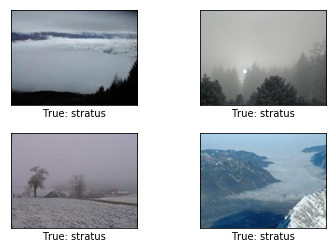

In [46]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:4])

# Get the true classes for those images.
cls_true = cls_test[0:4]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [47]:
path_tfrecords_train = os.path.join(cloudy.data_dir, "train.tfrecords")
path_tfrecords_train

'data/clouds-images/train.tfrecords'

In [48]:
path_tfrecords_test = os.path.join(cloudy.data_dir, "test.tfrecords")
path_tfrecords_test

'data/clouds-images/test.tfrecords'

In [49]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [50]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [51]:
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [55]:
def convert(image_paths, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    
    print("Converting: " + out_path)
    
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)
    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:
        
        # Iterate over all the image-paths and class-labels.
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)

            # Load the image-file using matplotlib's imread function.
            #img = imread(path)
            img = load_image(path)
        
            # Convert the image to raw bytes.
            img_bytes = img.tostring()

            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

In [56]:
convert(image_paths=image_paths_train,
        labels=cls_train,
        out_path=path_tfrecords_train)

Converting: data/clouds-images/train.tfrecords
- Progress: 100.0%

In [57]:
convert(image_paths=image_paths_test,
        labels=cls_test,
        out_path=path_tfrecords_test)

Converting: data/clouds-images/test.tfrecords
- Progress: 100.0%

In [58]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.decode_raw(image_raw, tf.uint8)
    
    #image=tf.reshape(image, image.shape)
    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=img_shape)
    
    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

In [59]:
def input_fn(filenames, train, batch_size=32, buffer_size=2048):
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)

    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    dataset = dataset.batch(batch_size)

    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch

    return x, y

In [60]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train, train=True)

In [61]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test, train=False)

In [62]:
some_images = load_images(image_paths=image_paths_test[0:4])

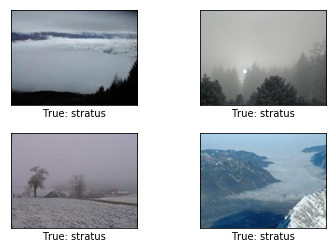

In [63]:
# Plot the images and labels using our helper-function above.
plot_images(images=some_images, cls_true=cls_true, smooth=True)

In [64]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(dtype=object)},
    num_epochs=1,
    shuffle=False)

In [65]:
some_images_cls = cls_test[0:4]

In [66]:
some_images_cls

array([0, 0, 0, 0])

In [67]:
img_shape

[224, 224, 3]

In [68]:
feature_image = tf.feature_column.numeric_column("image",
                                                 shape=img_shape)

In [69]:
feature_columns = [feature_image]

In [70]:
feature_columns

[_NumericColumn(key='image', shape=(224, 224, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [71]:
num_hidden_units = [512, 256, 128]

In [72]:
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   n_classes=num_classes,
                                   model_dir="./checkpoints_for_cloudify/",
                                   optimizer=tf.train.AdamOptimizer(1e-4),
                                   dropout=0.1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecf00627b8>, '_task_id': 0, '_num_ps_replicas': 0, '_evaluation_master': '', '_task_type': 'worker', '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_master': '', '_service': None, '_is_chief': True, '_model_dir': './checkpoints_for_cloudify/', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_train_distribute': None, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_save_checkpoints_steps': None}


In [73]:
model.train(input_fn=train_input_fn, steps=200) # lets use 50 steps instead of #200)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_for_cloudify/model.ckpt-800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 801 into ./checkpoints_for_cloudify/model.ckpt.
INFO:tensorflow:step = 801, loss = 40.972073
INFO:tensorflow:global_step/sec: 1.93214
INFO:tensorflow:step = 901, loss = 41.176823 (51.758 sec)
INFO:tensorflow:Saving checkpoints for 1000 into ./checkpoints_for_cloudify/model.ckpt.
INFO:tensorflow:Loss for final step: 40.42701.


In [74]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-04-13:09:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_for_cloudify/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-04-13:09:26
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.25, average_loss = 1.4181782, global_step = 1000, loss = 28.363564


In [75]:
result

{'accuracy': 0.25,
 'average_loss': 1.4181782,
 'global_step': 1000,
 'loss': 28.363564}

In [76]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

Classification accuracy: 25.00%


In [77]:
predictions = model.predict(input_fn=predict_input_fn)

In [78]:
cls = [p['classes'] for p in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_for_cloudify/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InternalError'>, Unable to get element as bytes.


InternalError: Unable to get element as bytes.

In [ ]:
cls

In [ ]:
cls_pred = np.array(cls, dtype='int').squeeze()
cls_pred

### Predictions for the Entire Test-Set

In [ ]:
predictions = model.predict(input_fn=test_input_fn)

In [ ]:
cls = [p['classes'] for p in predictions]

In [ ]:
cls_pred = np.array(cls, dtype='int').squeeze()

In [ ]:
cls_pred

In [ ]:
# Note we have 4 classes 

In [ ]:
np.sum(cls_pred == 4) # which should print 

## New estimator

If you cannot use one of the built-in Estimators, then you can create an arbitrary TensorFlow model yourself. To do this, you first need to create a function which defines the following:

1. The TensorFlow model, e.g. a Convolutional Neural Network.
2. The output of the model.
3. The loss-function used to improve the model during optimization.
4. The optimization method.
5. Performance metrics.

The Estimator can be run in three modes: Training, Evaluation, or Prediction. The code is mostly the same, but in Prediction-mode we do not need to setup the loss-function and optimizer.

This is another aspect of the Estimator API that is poorly designed and resembles how we did ANSI C programming using structs in the old days. It would probably have been more elegant to split this into several functions and sub-classed the Estimator-class.

In [87]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "image" in the input-function.
    x = features["image"]

    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1, img_size, img_size, num_channels])    
    #net = tf.reshape(x, [-1, 224, 224, 3])    
    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=3,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

    # Second convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv2',
                           filters=32, kernel_size=3,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)    

    # Flatten to a 2-rank tensor.
    net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    # net = tf.layers.flatten(net)

    # First fully-connected / dense layer.
    # This uses the ReLU activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc1',
                          units=128, activation=tf.nn.relu)    

    # Second fully-connected / dense layer.
    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc_2',
                          units=num_classes)

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        loss = tf.reduce_mean(cross_entropy)

        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])

        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())

        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls)
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

In [88]:
params = {"learning_rate": 1e-4}

In [89]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir="./checkpoints_for_cloudify/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fecf1bf22e8>, '_task_id': 0, '_num_ps_replicas': 0, '_evaluation_master': '', '_task_type': 'worker', '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_master': '', '_service': None, '_is_chief': True, '_model_dir': './checkpoints_for_cloudify/', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_train_distribute': None, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_save_checkpoints_steps': None}


In [90]:
model.train(input_fn=train_input_fn, steps=200)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints_for_cloudify/model.ckpt-1000


NotFoundError: Key beta1_power not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_INT64, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sibonelo/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sibonelo/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/sibonelo/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/sibonelo/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sibonelo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sibonelo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sibonelo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-116e601eb599>", line 1, in <module>
    model.train(input_fn=train_input_fn, steps=200)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 363, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 843, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 859, in _train_model_default
    saving_listeners)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 1056, in _train_with_estimator_spec
    log_step_count_steps=self._config.log_step_count_steps) as mon_sess:
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 405, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 816, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 539, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 1002, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 1007, in _create_session
    return self._sess_creator.create_session()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 696, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 458, in create_session
    self._scaffold.finalize()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/monitored_session.py", line 214, in finalize
    self._saver.build()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 829, in _build_internal
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 525, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key beta1_power not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_INT64, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [ ]:
result = model.evaluate(input_fn=test_input_fn)